In [113]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from keras.models import load_model
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
import shap
from scipy.stats import pearsonr
import sys
sys.path.insert(0, '/Users/huripari/Documents/PhD/TCs_Genesis/FS_TCG')
import utils_results as ut

In [114]:
basin = 'GLB'
run_name = 'selfeat50_top20_DSnc12_nv8_nd9'
years = np.arange(1980, 2022, 1) # from 1980 to 2021 included
n_folds = 3
n_clusters = int(run_name.split('nc')[1].split('_')[0])
nc_string = run_name.split('_')[2]
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
fs_dir = os.path.join(project_dir, 'FS_TCG')

In [115]:
# Get the run info and data
run_info = ut.runs_info(basin, run_name)
dataset_opt = run_info[0]
dataset_opt_noFS = run_info[1]
Y_pred = run_info[2]
Y_pred_noFS = run_info[3]
Y_test = run_info[4]
X_test_eval = run_info[5]
X_test_eval_noFS = run_info[6]
mlps = run_info[7]
mlps_noFS = run_info[8]
perm_importance_mlp = run_info[9]
perm_importance_mlp_noFS = run_info[10]
shap_values_mlp = run_info[11]
shap_values_mlp_noFS = run_info[12]
X_test = pd.concat(X_test_eval)
X_test_noFS = pd.concat(X_test_eval_noFS)

In [116]:
# Load the seasonality if working with deseason data
if "DS" in nc_string:
    cluster_data = f'{basin}_{n_clusters}clusters_deseason'
    data_dir = os.path.join(fs_dir, 'data', cluster_data)
    target_season = 'target_seasonality_1970-2022_2.5x2.5.csv'
    target_season_df = pd.read_csv(os.path.join(data_dir, target_season), index_col=0)
    target_season_df.index = pd.to_datetime(target_season_df.index)

**Time series Trajectories** 

In [117]:
# Concat the predictions and the test values
Y_pred_df = pd.concat(Y_pred)
Y_test_df = pd.concat(Y_test)
Y_pred_noFS_df = pd.concat(Y_pred_noFS)
if "DS" in nc_string:
    Y_pred_df['tcg'] = Y_pred_df['tcg'] + target_season_df.loc[Y_pred_df.index, 'seasonal']
    Y_test_df = Y_test_df + target_season_df.loc[Y_test_df.index, 'seasonal']
    Y_pred_noFS_df['tcg'] = Y_pred_noFS_df['tcg'] + target_season_df.loc[Y_pred_noFS_df.index, 'seasonal']
    # values smaller than 0 are set to 0
    Y_pred_df.loc[Y_pred_df['tcg'] < 0, 'tcg'] = 0.0
    Y_pred_noFS_df.loc[Y_pred_noFS_df['tcg'] < 0, 'tcg'] = 0.0
# Compute seasonal mean values
Y_pred_df_season = Y_pred_df.groupby(Y_pred_df.index.month).mean()
Y_test_df_season = Y_test_df.groupby(Y_test_df.index.month).mean()
Y_pred_noFS_df_season = Y_pred_noFS_df.groupby(Y_pred_noFS_df.index.month).mean()
# Compute annual cumulative values
Y_pred_df_annual = Y_pred_df.groupby(Y_pred_df.index.year).sum()
Y_test_df_annual = Y_test_df.groupby(Y_test_df.index.year).sum()
Y_pred_noFS_df_annual = Y_pred_noFS_df.groupby(Y_pred_noFS_df.index.year).sum()
# Compute the correlation coefficient and the MSE between the predictions and the test values
# Monthly
r, _ = pearsonr(Y_test_df, Y_pred_df['tcg'])
mse = mean_squared_error(Y_test_df, Y_pred_df['tcg'])
r_noFS, _ = pearsonr(Y_test_df, Y_pred_noFS_df['tcg'])
mse_noFS = mean_squared_error(Y_test_df, Y_pred_noFS_df['tcg'])
print('========== Monthly =========')
print(f'FS  -  r: {r:.3f}, mse: {mse:.3f}')
print(f'NoFS - r: {r_noFS:.3f}, mse: {mse_noFS:.3f}')
# Seasonal
rS, _ = pearsonr(Y_test_df_season, Y_pred_df_season['tcg'])
mseS = mean_squared_error(Y_test_df_season, Y_pred_df_season['tcg'])
rS_noFS, _ = pearsonr(Y_test_df_season, Y_pred_noFS_df_season['tcg'])
mseS_noFS = mean_squared_error(Y_test_df_season, Y_pred_noFS_df_season['tcg'])
print('========== Seasonal ========')
print(f'FS  -  r: {rS:.3f}, mse: {mseS:.3f}')
print(f'NoFS - r: {rS_noFS:.3f}, mse: {mseS_noFS:.3f}')
# Annual
rY, _ = pearsonr(Y_test_df_annual, Y_pred_df_annual['tcg'])
mseY = mean_squared_error(Y_test_df_annual, Y_pred_df_annual['tcg'])
rY_noFS, _ = pearsonr(Y_test_df_annual, Y_pred_noFS_df_annual['tcg'])
mseY_noFS = mean_squared_error(Y_test_df_annual, Y_pred_noFS_df_annual['tcg'])
print('========== Annual ==========')
print(f'FS  -  r: {rY:.3f}, mse: {mseY:.3f}')
print(f'NoFS - r: {rY_noFS:.3f}, mse: {mseY_noFS:.3f}')


========== Monthly =========
FS  -  r: 0.809, mse: 5.278
NoFS - r: 0.815, mse: 5.147
========== Seasonal ========
FS  -  r: 0.999, mse: 0.112
NoFS - r: 0.999, mse: 0.121
========== Annual ==========
FS  -  r: 0.328, mse: 70.093
NoFS - r: -0.097, mse: 104.081


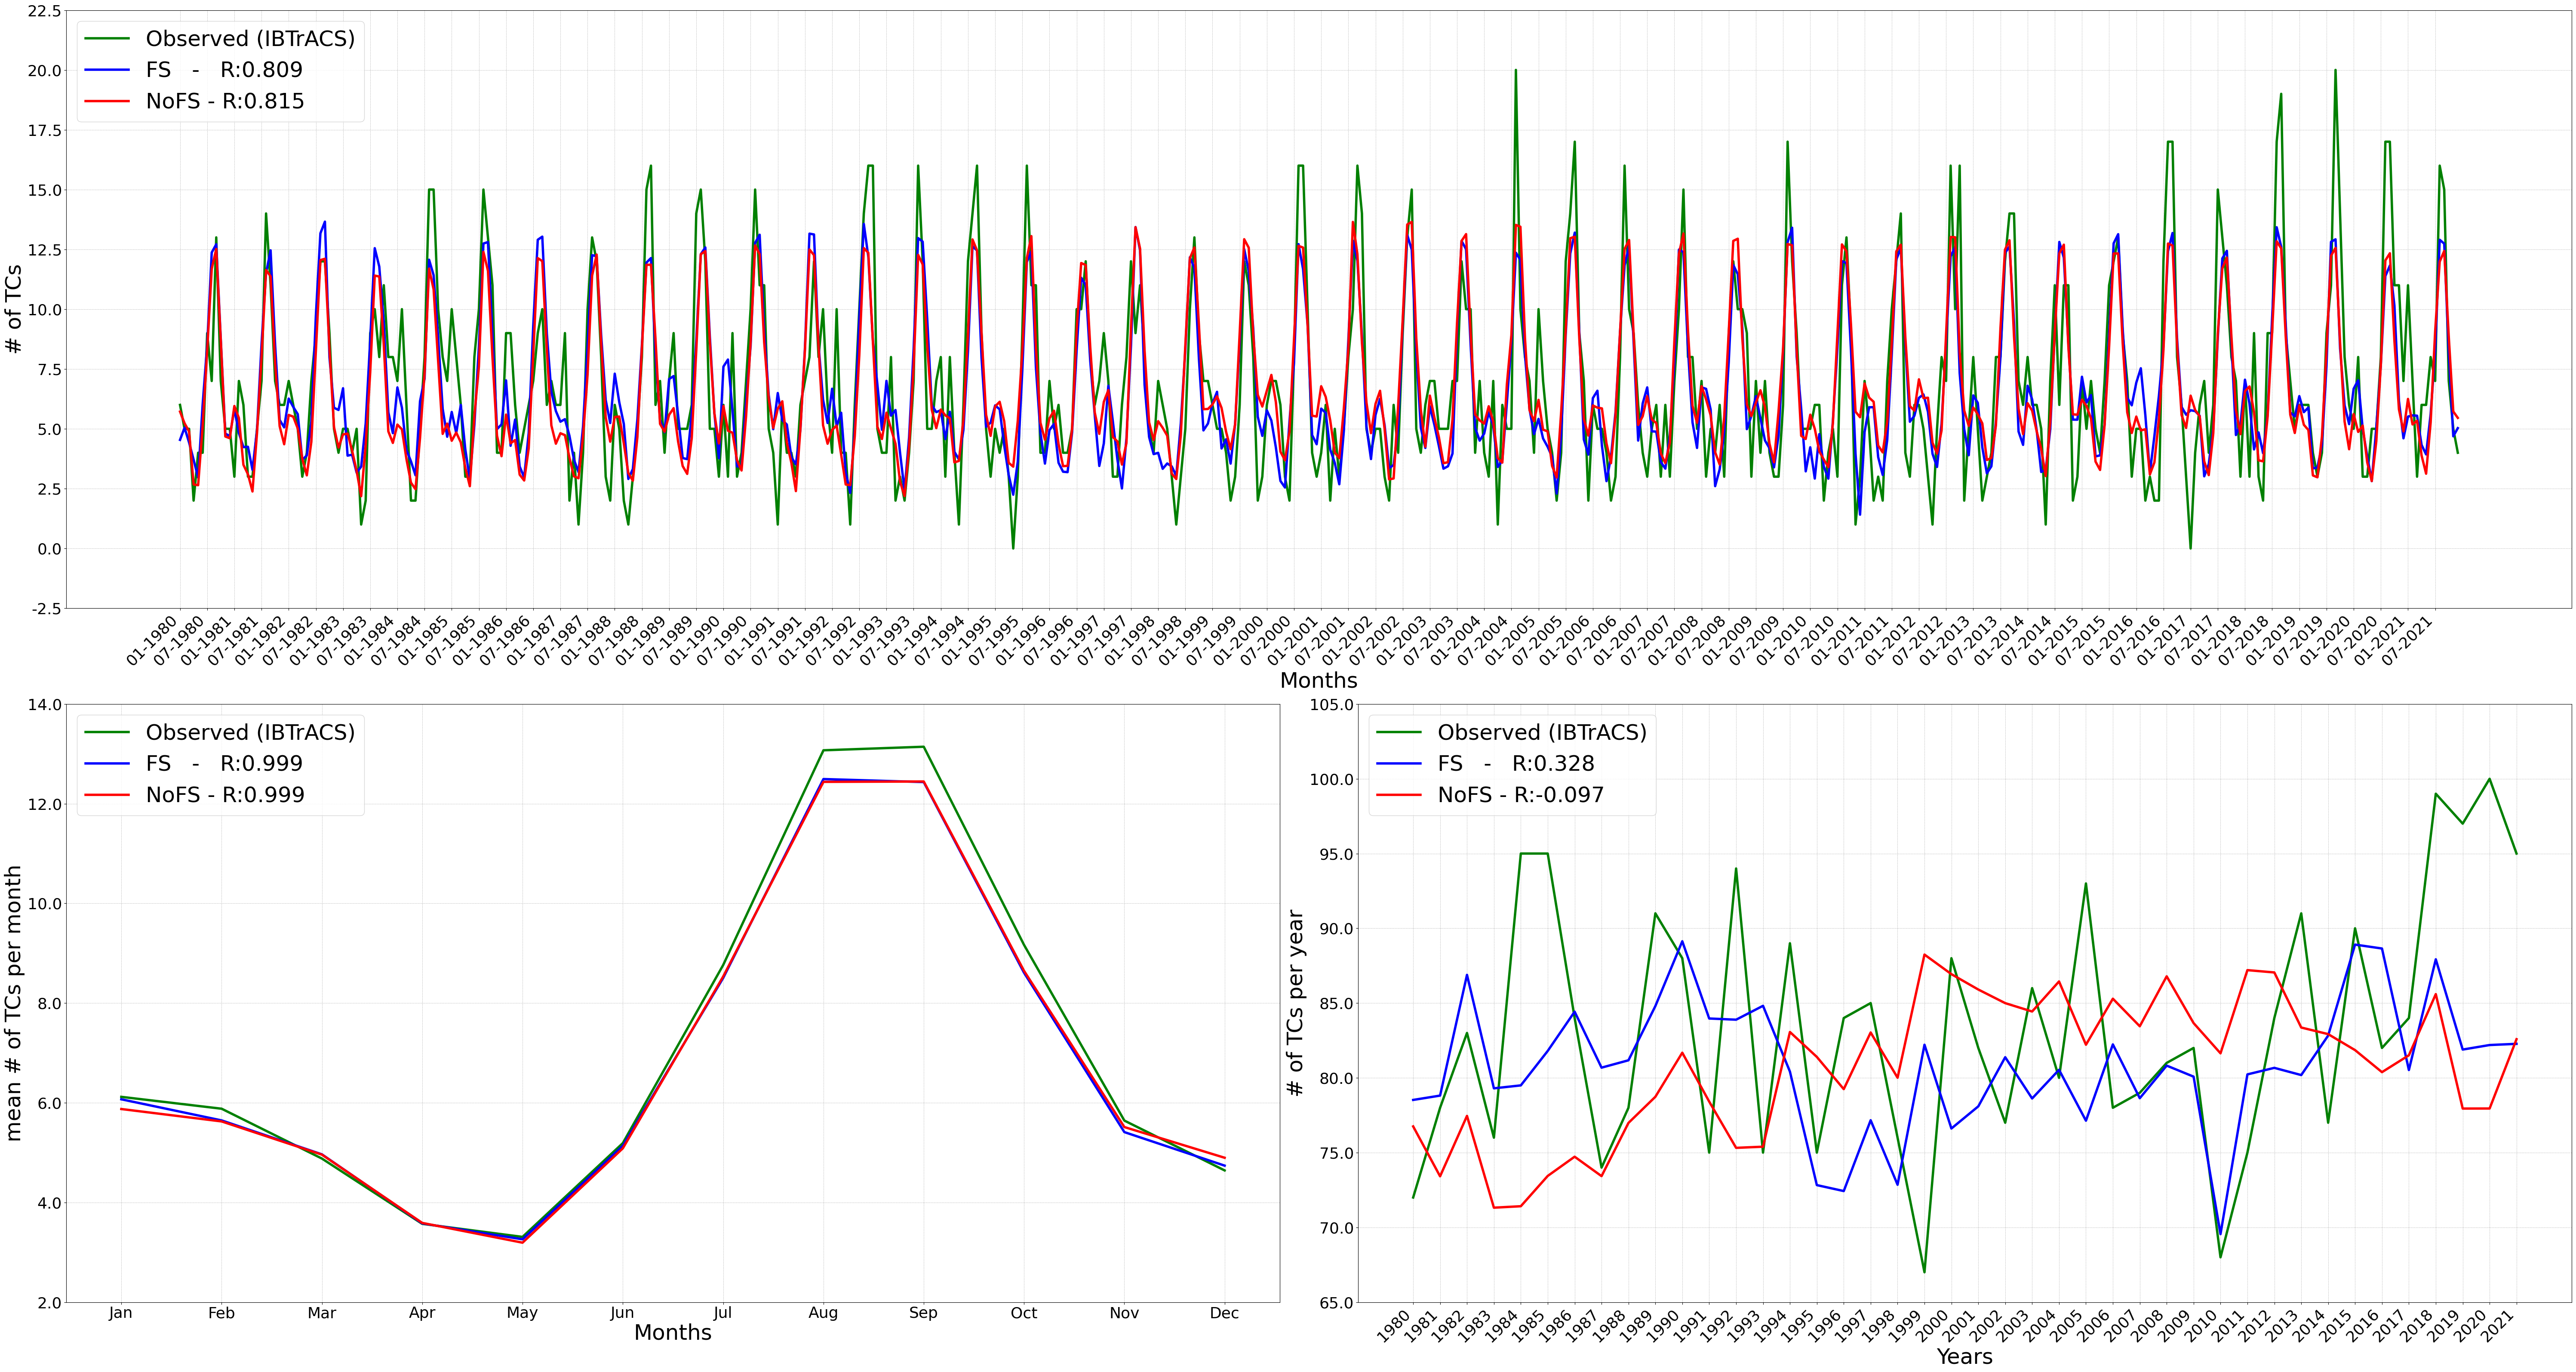

In [118]:
# Plot Time Series 
fig_ts = plt.figure(figsize=(60, 32))
gs = gridspec.GridSpec(2, 2, figure=fig_ts)
# monthly time series
ax = fig_ts.add_subplot(gs[0, :])
xticks = pd.Series(Y_test_df.index).dt.strftime('%m-%Y').to_numpy()
# observations
ax.plot(xticks, Y_test_df, label='Observed (IBTrACS)', color='green', linewidth=4)
# predictions
ax.plot(xticks, Y_pred_df['tcg'], label=f'FS   -   R:{r:.3f}', color='blue', linewidth=4)
ax.plot(xticks, Y_pred_noFS_df['tcg'], label=f'NoFS - R:{r_noFS:.3f}', color='red', linewidth=4)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xticks(ticks=np.arange(len(xticks))[::6])
ax.set_xticklabels(xticks[::6], rotation=45, fontsize=26, ha='right')
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticks(), fontsize=26)
ax.set_xlabel('Months', fontsize=36)
ax.set_ylabel('# of TCs', fontsize=36)
ax.legend(fontsize=36, loc='upper left')
# seasonal time series
axS = fig_ts.add_subplot(gs[1, 0])
# observations
axS.plot(Y_test_df_season.index, Y_test_df_season, label='Observed (IBTrACS)', color='green', linewidth=4)
# mlp predictions
axS.plot(Y_pred_df_season.index, Y_pred_df_season['tcg'], label=f'FS   -   R:{rS:.3f}', color='blue', linewidth=4)
axS.plot(Y_pred_noFS_df_season.index, Y_pred_noFS_df_season['tcg'], label=f'NoFS - R:{rS_noFS:.3f}', color='red', linewidth=4)
axS.grid(True, which='both', linestyle='--', linewidth=0.5)
axS.set_xticks(Y_test_df_season.index)
axS.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=26)
axS.set_yticks(axS.get_yticks())
axS.set_yticklabels(axS.get_yticks(), fontsize=26)
axS.set_xlabel('Months', fontsize=36)
axS.set_ylabel('mean # of TCs per month', fontsize=36)
axS.legend(fontsize=36, loc='upper left')
# Annual time series
axY = fig_ts.add_subplot(gs[1, 1])
# observations
axY.plot(Y_test_df_annual.index, Y_test_df_annual, label='Observed (IBTrACS)', color='green', linewidth=4)
# mlp predictions
axY.plot(Y_pred_df_annual.index, Y_pred_df_annual['tcg'], label=f'FS   -   R:{rY:.3f}', color='blue', linewidth=4)
axY.plot(Y_pred_noFS_df_annual.index, Y_pred_noFS_df_annual['tcg'], label=f'NoFS - R:{rY_noFS:.3f}', color='red', linewidth=4)
axY.grid(True, which='both', linestyle='--', linewidth=0.5)
axY.set_xticks(Y_test_df_annual.index)
axY.set_xticklabels(Y_test_df_annual.index, rotation=45, fontsize=26, ha='right')
axY.set_yticks(axY.get_yticks())
axY.set_yticklabels(axY.get_yticks(), fontsize=26)
axY.set_xlabel('Years', fontsize=36)
axY.set_ylabel('# of TCs per year', fontsize=36)
axY.legend(fontsize=36, loc='upper left')

fig_ts.set_tight_layout(True)
plt.show()

**Permutation Importance**

Permutation feature importance is a model inspection technique that measures the contribution of each feature to a fitted model’s statistical performance on a given tabular dataset. This technique is particularly useful for non-linear or opaque estimators, and involves randomly shuffling the values of a single feature and observing the resulting degradation of the model’s score [1]. By breaking the relationship between the feature and the target, we determine how much the model relies on such particular feature.

The estimator is required to be a fitted estimator. X can be the data set used to train the estimator or a hold-out set. The permutation importance of a feature is calculated as follows. First, a baseline metric, defined by scoring, is evaluated on a (potentially different) dataset defined by the X. Next, a feature column from the validation set is permuted and the metric is evaluated again. The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.

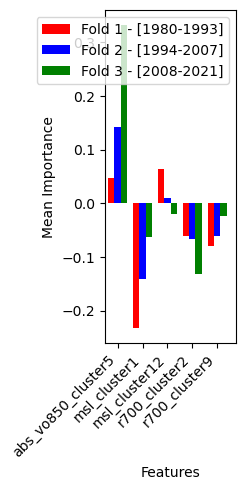

In [119]:
# Mean importance of the features by fold models
colors = ['red', 'blue', 'green']
plt.figure(figsize=(X_test.shape[1]/2, 5))
bar_width = 0.25 

kfold = KFold(n_splits=n_folds)
for nf, (train_index, test_index) in enumerate(kfold.split(years)):
    test_years = years[test_index]
    xt = X_test_eval[nf]
    feature_importance = perm_importance_mlp[nf]["importances_mean"]
    bar_positions = np.arange(xt.shape[1]) + nf * bar_width  # offset each bar
    plt.bar(bar_positions, feature_importance, width=bar_width, align="center", color=colors[nf], label=f'Fold {nf+1} - [{test_years[0]}-{test_years[-1]}]')

x_labels = ['{}'.format(col.split('_l')[0]) for col in np.array(xt.columns)]
plt.xticks(np.arange(xt.shape[1]) + bar_width, x_labels, rotation=45, ha='right')

plt.xlabel("Features")
plt.ylabel("Mean Importance")
plt.legend()
plt.xlim([-1 * bar_width, xt.shape[1]])
plt.tight_layout()
plt.show()

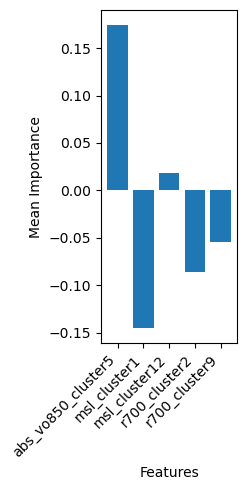

In [120]:
# Mean of mean importance of the features
mean_perm_importance = np.mean(np.array([perm_importance_mlp[nf]["importances_mean"] for nf in range(n_folds)]), axis=0)
plt.figure(figsize=(xt.shape[1]/2, 5))
bar_positions = np.arange(xt.shape[1]) + bar_width
plt.bar(bar_positions, mean_perm_importance, align="center", label='Mean Importance')
x_labels = ['{}'.format(col.split('_l')[0]) for col in np.array(xt.columns)]
plt.xticks(np.arange(xt.shape[1]) + bar_width, x_labels, rotation=45, ha='right')
plt.xlabel("Features")
plt.ylabel("Mean Importance")
plt.tight_layout()
plt.show()

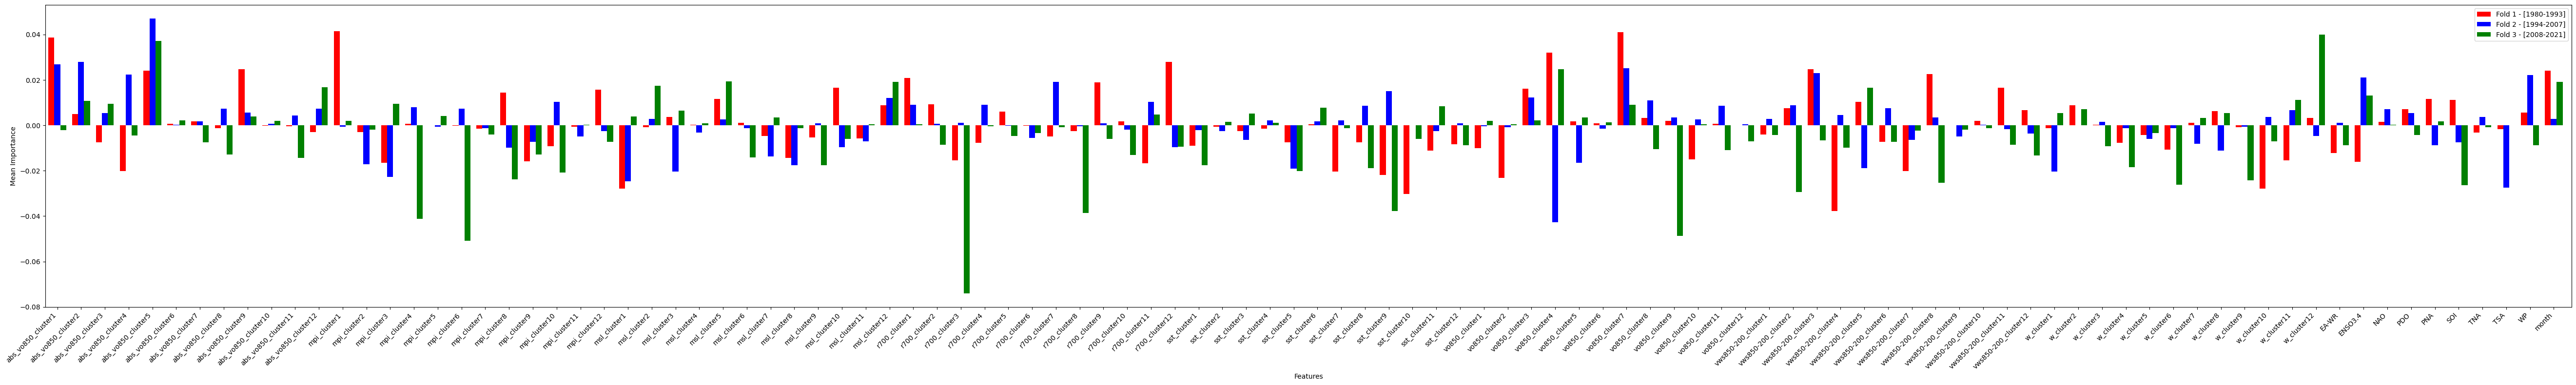

In [121]:
colors = ['red', 'blue', 'green']
plt.figure(figsize=(X_test_noFS.shape[1]/2, 8))
bar_width = 0.25 

for nf, (train_index, test_index) in enumerate(kfold.split(years)):
    test_years = years[test_index]
    feature_importance = perm_importance_mlp_noFS[nf]["importances_mean"]
    bar_positions = np.arange(X_test_noFS.shape[1]) + nf * bar_width  # offset each bar
    plt.bar(bar_positions, feature_importance, width=bar_width, align="center", color=colors[nf], label=f'Fold {nf+1} - [{test_years[0]}-{test_years[-1]}]')

x_labels = ['{}'.format(col.split('_l')[0]) for col in np.array(X_test_noFS.columns)]
plt.xticks(np.arange(X_test_noFS.shape[1]) + bar_width, x_labels, rotation=45, ha='right')

plt.xlabel("Features")
plt.ylabel("Mean Importance")
plt.legend()
plt.xlim([-1 * bar_width, X_test_noFS.shape[1]])
plt.tight_layout()
plt.show()

**SHAP values**

SHAP values, which measure how much each feature (such as income, age, credit score, etc.) contributes to the model's prediction. 
SHAP (SHapley Additive exPlanations) values are a way to explain the output of any machine learning model. It uses a game theoretic approach that measures each player's contribution to the final outcome. In machine learning, each feature is assigned an importance value representing its contribution to the model's output. SHAP values show how each feature affects each final prediction, the significance of each feature compared to others, and the model's reliance on the interaction between features. 
Features with positive SHAP values positively impact the prediction, while those with negative values have a negative impact. The magnitude is a measure of how strong the effect is.

Properties of SHAP values:
1. Additivity
2. Local accuracy
3. Missingness
4. Consistency

At its core, SHAP values aim to assign a numerical value to each feature, showcasing how much that particular feature influenced the model’s prediction for a specific data point. By considering all possible combinations of features and their contributions, SHAP values offer a comprehensive understanding of feature importance within the model.

/opt/miniconda3/envs/weather/lib/python3.11/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


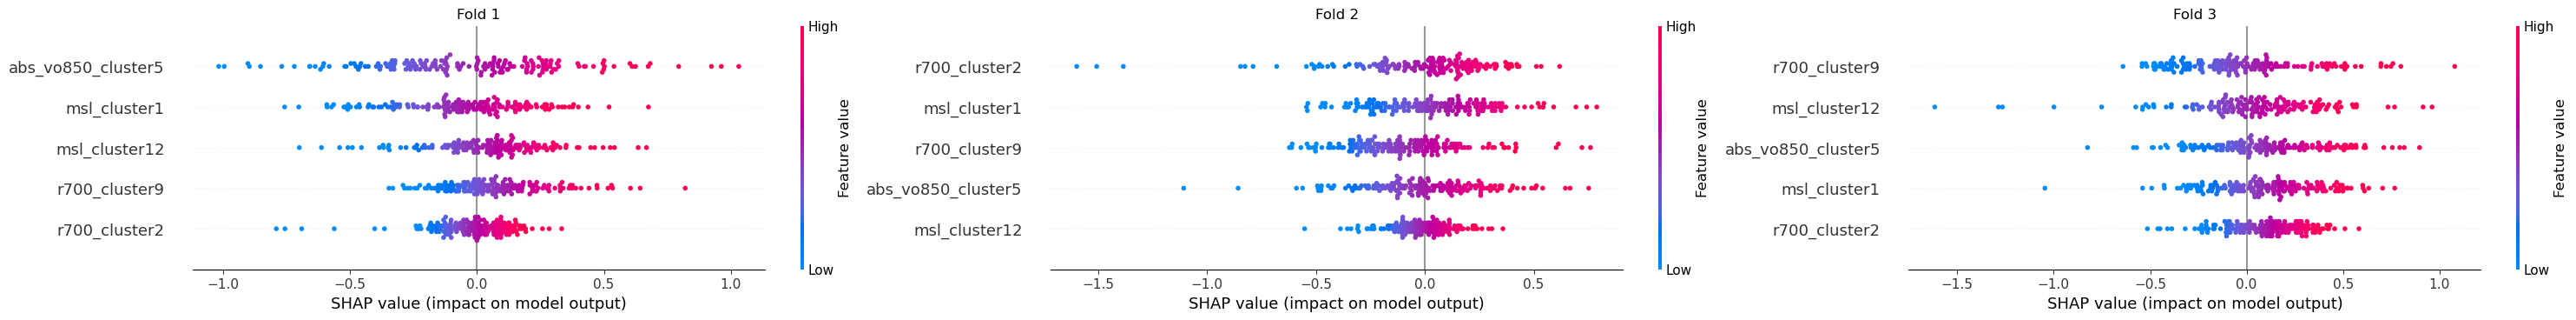

In [122]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for nf in range(3):
    plt.sca(axes[nf])
    shap.summary_plot(shap_values_mlp[nf], max_display=25, show=False)
    axes[nf].set_title(f'Fold {nf+1}') 

plt.subplots_adjust(left=0, right=3.5, wspace=0.2, bottom=0.1, top=0.9)
plt.show()

The beeswarm plot, often used in the context of SHAP values, provides a visual summary of feature importance across multiple instances or predictions. Observing a beeswarm plot can yield several insights:
1. _Feature Importance Spread_: The spread of points along the x-axis for each feature indicates the range and distribution of SHAP values across different instances. A wider spread signifies varying importance levels of that feature across the dataset.
2. _Relative Impact_: The horizontal position of the points for a feature showcases the magnitude of its impact on predictions. Features with points shifted to the right (higher SHAP values) indicate more substantial positive contributions, while those shifted to the left (lower SHAP values) represent negative contributions.
3. _Consistency of Feature Influence_: Consistent positions (clusters or consistent distributions) of points for a feature across different instances indicate its stable impact on predictions. Conversely, scattered or irregular distributions might imply fluctuating importance or varying effects.
4. _Comparative Importance_: Comparing the distribution and spread of points between different features allows you to assess their relative importance. Features with more spread-out or consistently shifted points might hold higher significance in the model’s predictions.
5. _Outliers and Anomalies_: Outlying points or clusters diverging from the main distribution for a feature might highlight specific instances where that feature has an unexpected or unique impact on predictions.
6. _Interactions between Features_: Beeswarm plots can reveal potential interactions or dependencies between features. If the distributions or positions of points change concerning specific combinations of features, it suggests potential interactions that influence predictions.
7. _Model Consistency_: Consistency in the distributions and positions of points across multiple models or model versions indicates robustness in feature importance assessments.

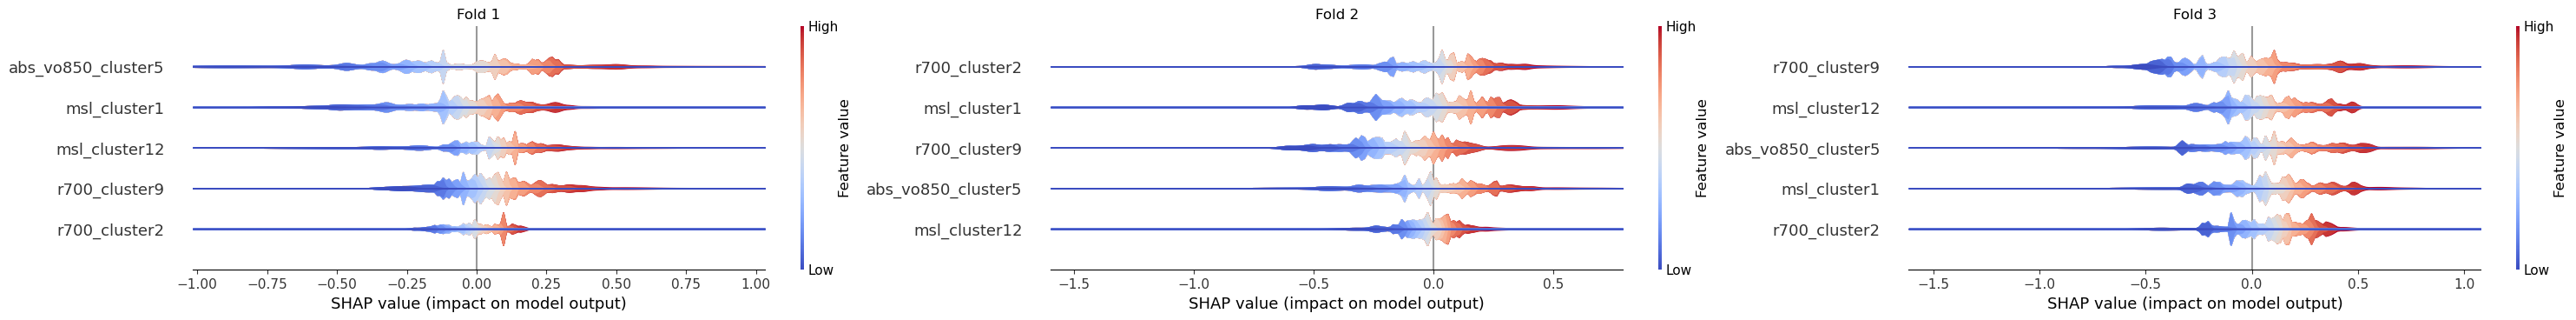

In [123]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for nf in range(3):
    plt.sca(axes[nf])
    shap.plots.violin(shap_values_mlp[nf], plot_type="layered_violin", max_display=25, show=False)
    axes[nf].set_title(f'Fold {nf+1}') 

plt.subplots_adjust(left=0, right=3.5, wspace=0.2, bottom=0.1, top=0.9)
plt.show()

Violin plots use “violin-shaped” figures to display the distribution and density of SHAP values for their respective feature. The violins can therefore provide insights into the range, variability, skewness, symmetry, and multimodality of the SHAP value distribution for a specific feature.
The overall violin summary plot allow for comparisons in feature importance. Wider violins indicate higher density and more frequent values, thus providing insights into the relative importance of each feature with regard to the model output.

The layered violin summary plot is identical to the violin one, except that outliers are not drawn as scatter points and it provides insights on the impact on the output of feature values (high/low) in the data. We can now also get get a sense of the direction of the impact from the data. Red represents large values of a variable, and blue represents small ones, for the considered feature.

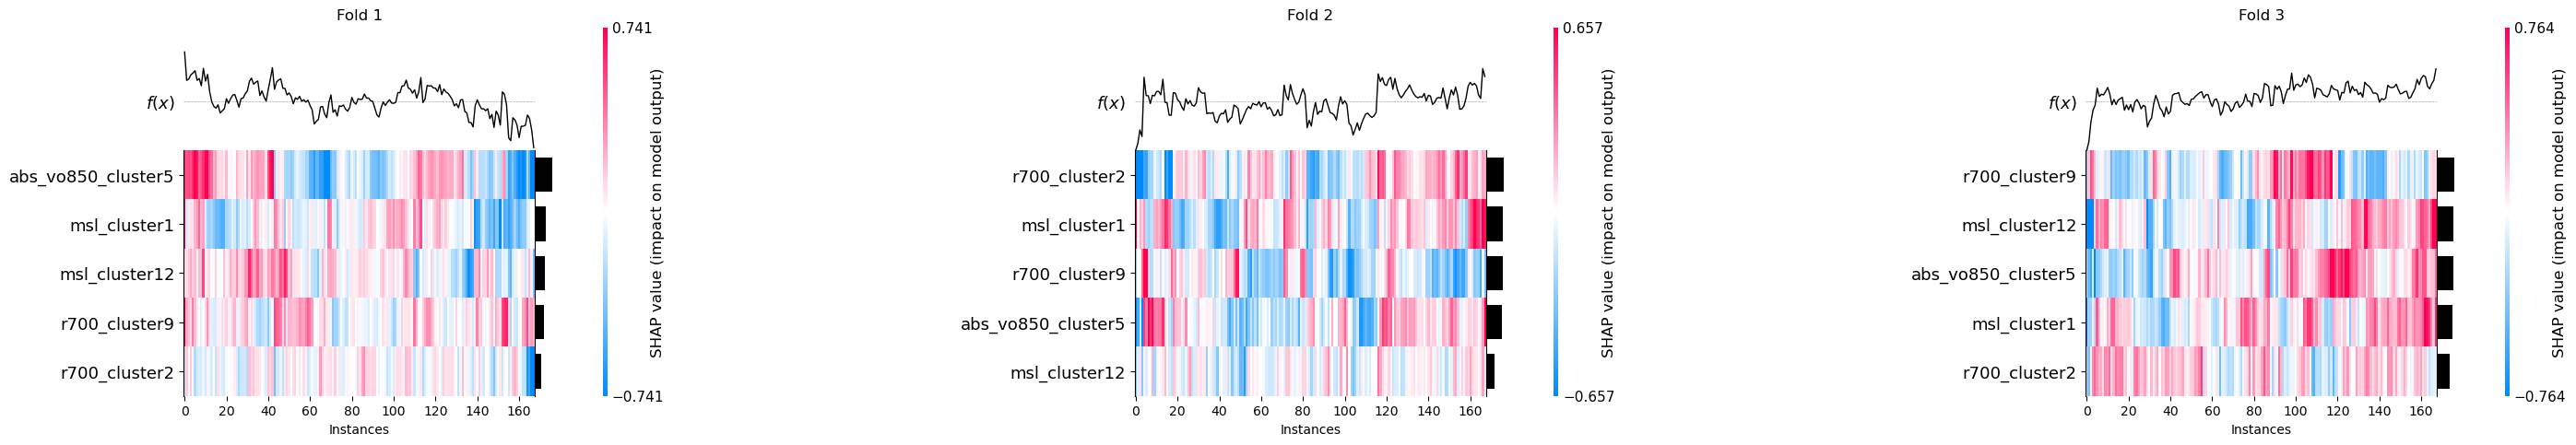

In [124]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for nf in range(3):
    plt.sca(axes[nf])
    shap.plots.heatmap(shap_values_mlp[nf], max_display=25, show=False)
    axes[nf].set_title(f'Fold {nf+1}') 

plt.subplots_adjust(left=0, right=3.5, wspace=0.4, bottom=0.1, top=0.9)
plt.show()

Passing a matrix of SHAP values to the heatmap plot function creates a plot with the instances on the x-axis, the model inputs on the y-axis, and the SHAP values encoded on a color scale. By default the samples are ordered using ```shap.order.hclust```, which orders the samples based on a hierarchical clustering by their explanation similarity. This results in samples that have the same model output for the same reason getting grouped together.

The output of the model is shown above the heatmap matrix (centered around the explaination’s ```.base_value```), and the global importance of each model input shown as a bar plot on the right hand side of the plot (by default this is the ```shap.order.abs.mean``` measure of overall importance).

In [48]:
# fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# for nf in range(3):
#     plt.sca(axes[nf])
#     shap.plots.heatmap(shap_values_mlp[nf], instance_order=shap_values_mlp[nf].values.sum(1), max_display=20, show=False)
#     axes[nf].set_title(f'Fold {nf+1}') 

# plt.subplots_adjust(left=0, right=3.5, wspace=0.4, bottom=0.1, top=0.9)
# plt.show()

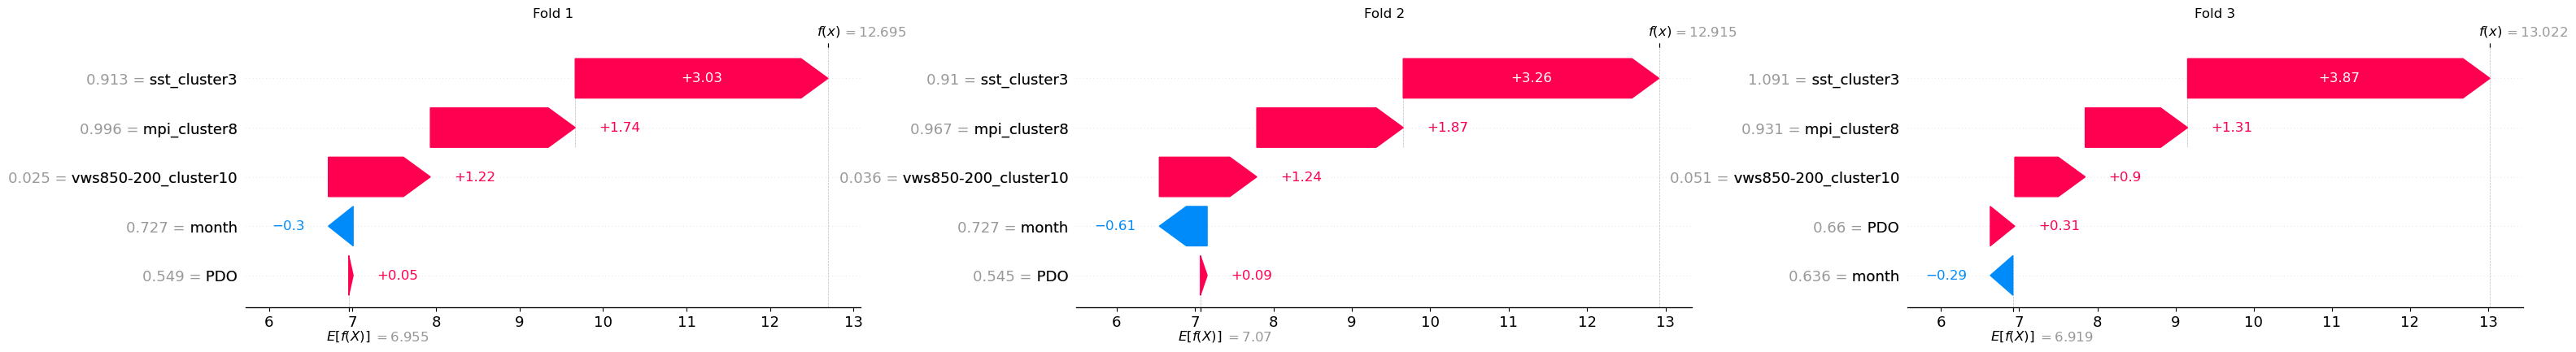

In [49]:
# Check waterfall plot for a specific prediction - prediction for max value
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for nf in range(3):
    sample_idx = Y_pred[nf].index.get_loc(Y_pred[nf].tcg.idxmax())
    plt.sca(axes[nf])
    shap.plots.waterfall(shap_values_mlp[nf][sample_idx], max_display=20, show=False)
    axes[nf].set_title(f'Fold {nf+1}') 

plt.subplots_adjust(left=0, right=3.5, wspace=0.35, bottom=0.1, top=0.9)
plt.show()


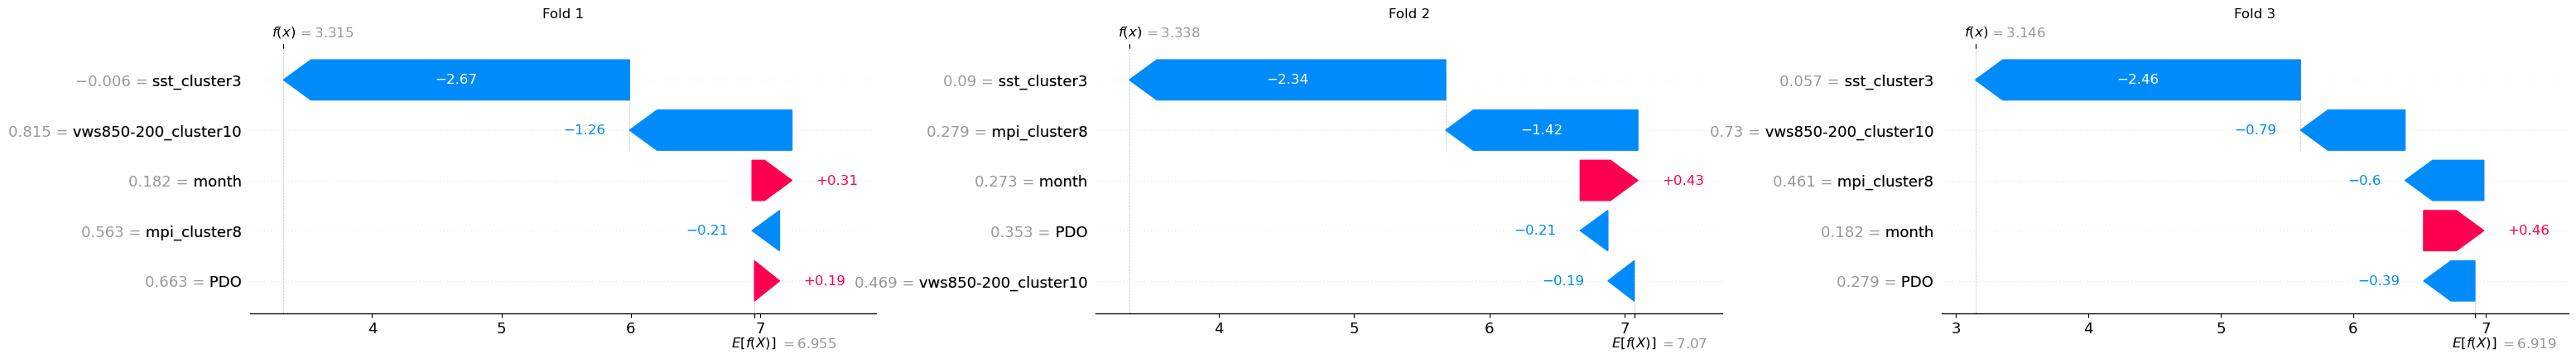

In [50]:
# Check waterfall plot for a specific prediction - prediction for min value
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for nf in range(3):
    sample_idx = Y_pred[nf].index.get_loc(Y_pred[nf].tcg.idxmin())
    plt.sca(axes[nf])
    shap.plots.waterfall(shap_values_mlp[nf][sample_idx], max_display=20, show=False)
    axes[nf].set_title(f'Fold {nf+1}') 

plt.subplots_adjust(left=0, right=3.5, wspace=0.35, bottom=0.1, top=0.9)
plt.show()

In [15]:
# shap.dependence_plot('sst_cluster6', shap_values_mlp[0].values, X_test_eval[0], interaction_index='mpi_cluster8')

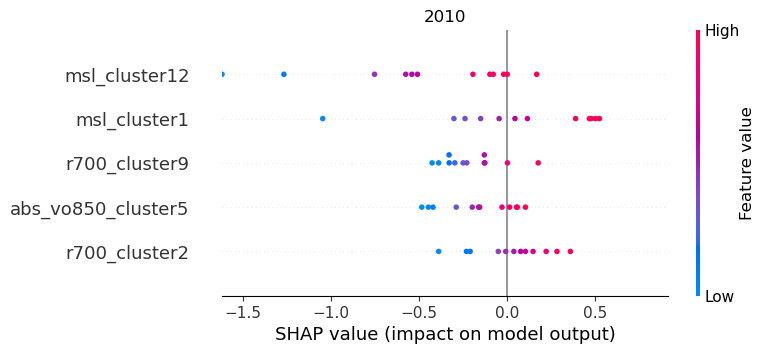

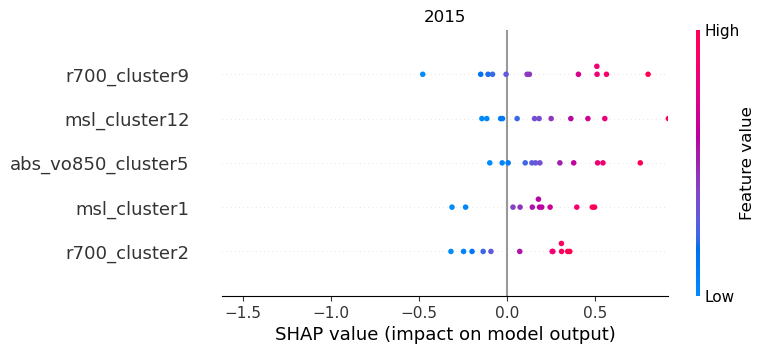

In [142]:
years_for_analysis = [2010, 2015] # 2010, 2015
shap_values3 = shap_values_mlp[2]
Y_test3 = Y_test[2]


indices = Y_test3.index.year == 2010
shap2010 = shap_values3[indices]
indices = Y_test3.index.year == 2015
shap2015 = shap_values3[indices]

# get min and max values for the x-axis
xmin = min(shap2010.values.min(), shap2015.values.min())
xmax = max(shap2010.values.max(), shap2015.values.max())

# get min and max values for the colorbar
vmin = min(shap2010.data.min(), shap2015.data.min())
vmax = max(shap2010.data.max(), shap2015.data.max())
    
plt.figure()
shap.summary_plot(shap2010, max_display=25, show=False)
plt.title('2010')
plt.xlim(xmin, xmax)
sm = plt.cm.ScalarMappable(cmap="coolwarm")
sm.set_clim(vmin, vmax)
# plt.colorbar(sm, label="Feature Value")

plt.figure()
shap.summary_plot(shap2015, max_display=25, show=False)
plt.title('2015')
plt.xlim(xmin, xmax)
sm = plt.cm.ScalarMappable(cmap="coolwarm")
sm.set_clim(vmin, vmax)
# plt.colorbar(sm, label="Feature Value")


**Correlation Matrices**

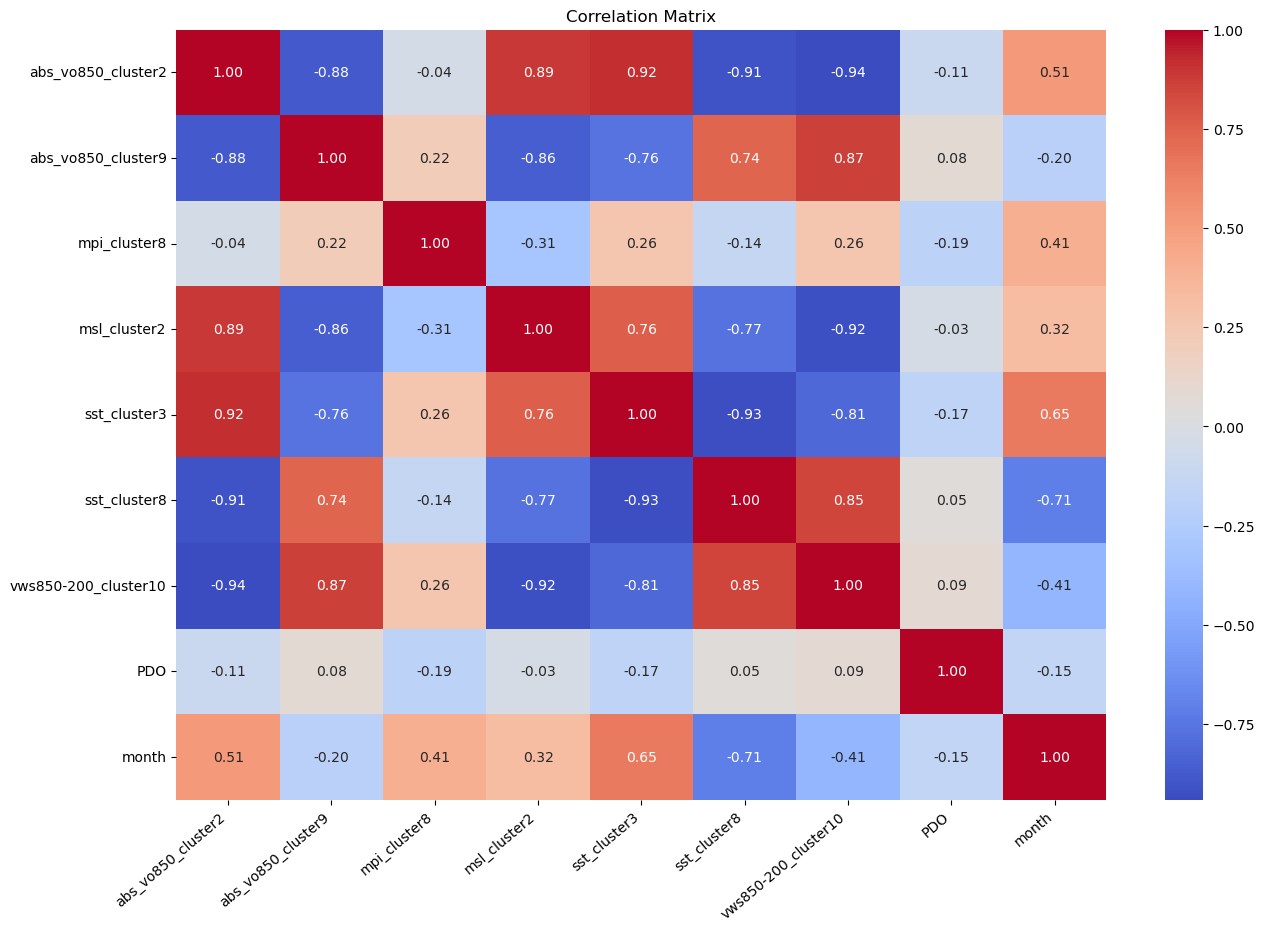

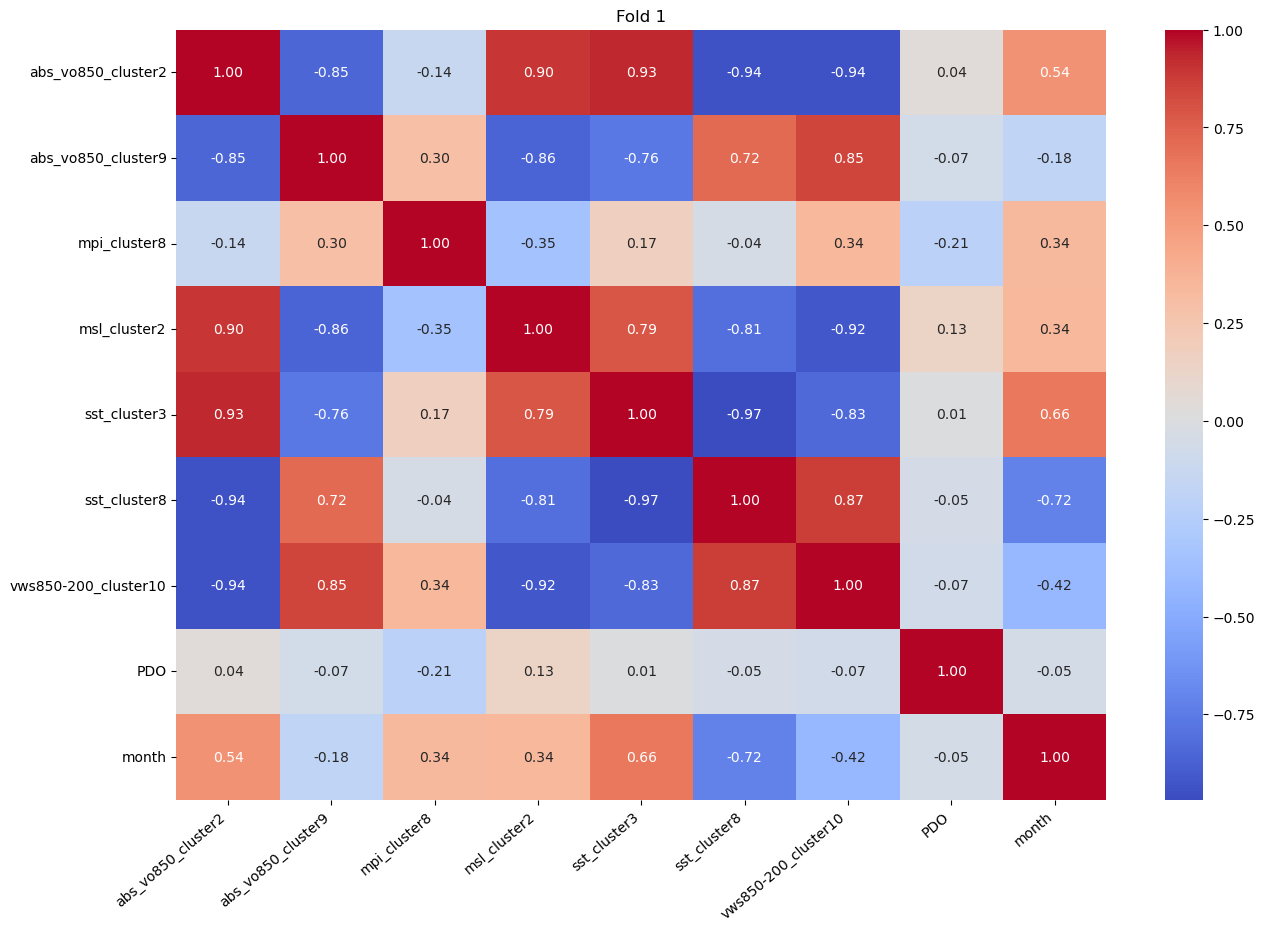

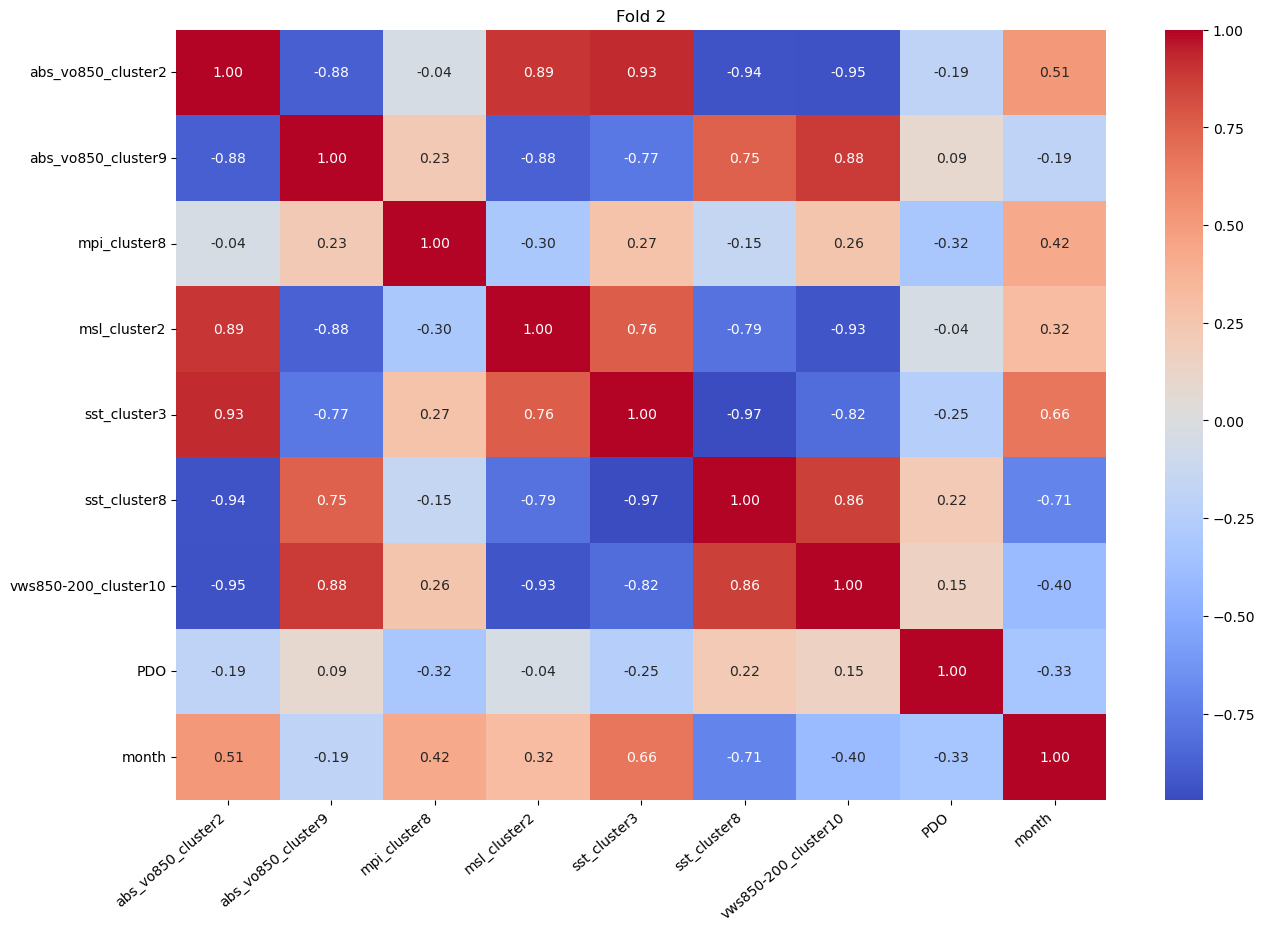

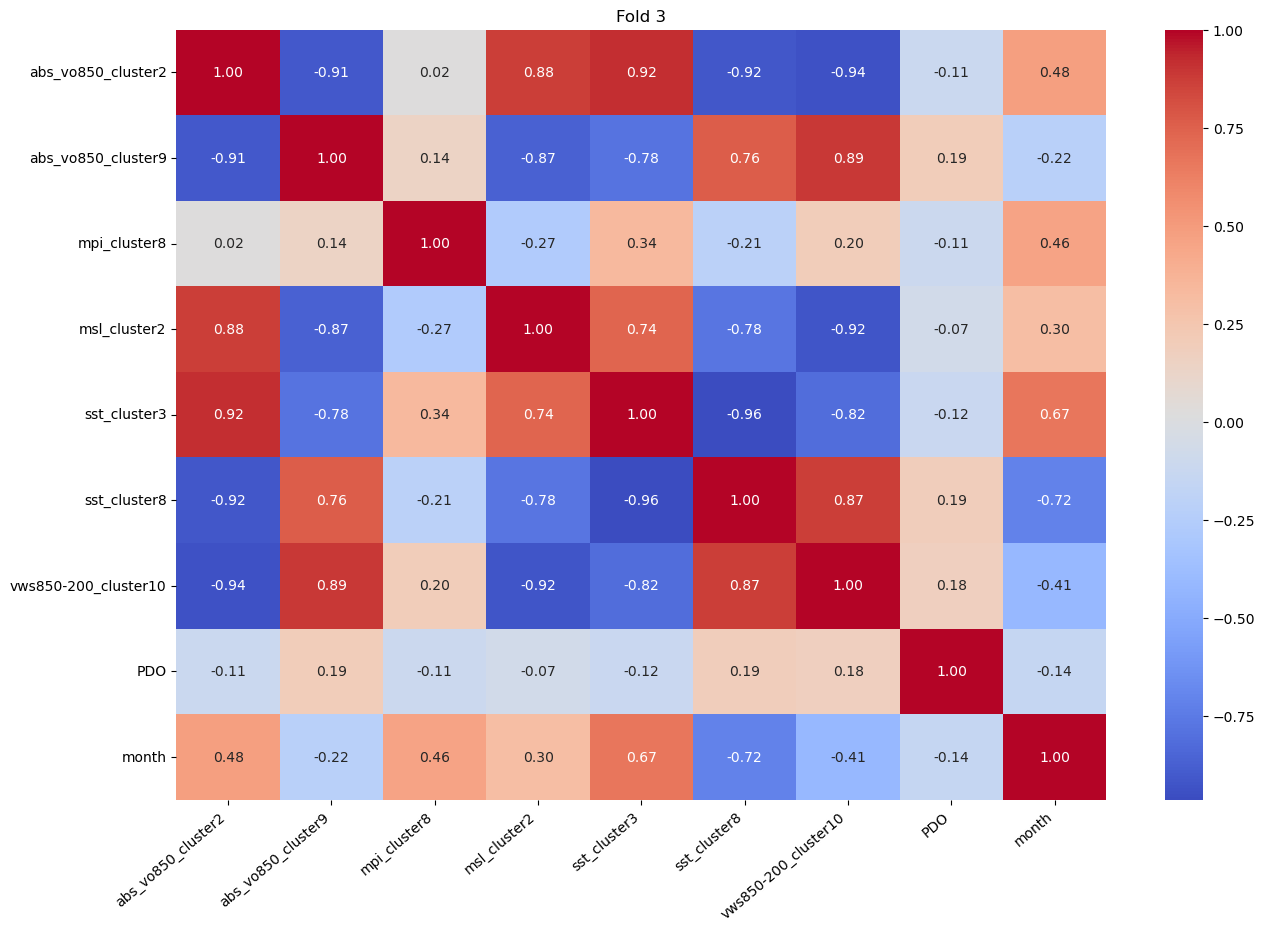

In [16]:
X_test = pd.concat([X_test_eval[0], X_test_eval[1], X_test_eval[2]], axis=0)
corr = X_test.corr()
fig = plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.xticks(rotation=40, ha='right')

for nf in range(3):
    corr = X_test_eval[nf].corr()
    fig = plt.figure(figsize=(15, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Fold {nf+1}')
    plt.xticks(rotation=40, ha='right')

plt.show()

**Clusters selected**

In [17]:
# sel_clusters_dir = os.path.join(figures_dir, 'clusters_selected')
# sel_clusters_figs = os.listdir(sel_clusters_dir)
# for fig_name in sel_clusters_figs:
#     fig_path = os.path.join(sel_clusters_dir, fig_name)
#     fig = ut.load_pdf_convert_to_image(fig_path)
#     display(fig)